# Прогноз количества заказов такси

**Цель** - построить модель для предсказания количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. 

Значение метрики RMSE на тестовой выборке должно быть не больше 48.



## Cодержание
1. Описание проекта
1. Загрузка и изучение данных
1. Ресемплирование на часовом таймфрейме
1. Анализ
1. Обучение моделей
1. Тестирование

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
#from IPython.display import Markdown as md

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

Загружаем данные, сразу преобразовываем первый столбец в формат datetime и используем его в качестве индекса:

In [2]:
path = ''
df = pd.read_csv(path + 'taxi.csv', parse_dates=[0], index_col='datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sum()

num_orders    372811
dtype: int64

In [5]:
print(df.index.min(), '-', df.index.max())

2018-03-01 00:00:00 - 2018-08-31 23:50:00


In [6]:
print(df.index.is_monotonic)

True


- Видим, что пропущенных значений нет, данные представлены за период с 01 марта по 31 августа 2018 года с периодичностью в 10 минут, суммарное количество заказов 372811 шт, хронологический порядок не нарушен.

# Ресемплирование на часовом таймфрейме
Выполним ресемплирование данных на часовой таймфрейме (ввел M60 обозначение - 60 минутный интервал).

In [7]:
df_M60 = df.copy()
df_M60 = df_M60.resample('1H').sum()
df_M60.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Анализ

Разложим временной ряд на составляющие: тренд, сезонность и остаток.


In [8]:
decomposed = seasonal_decompose(df_M60) 

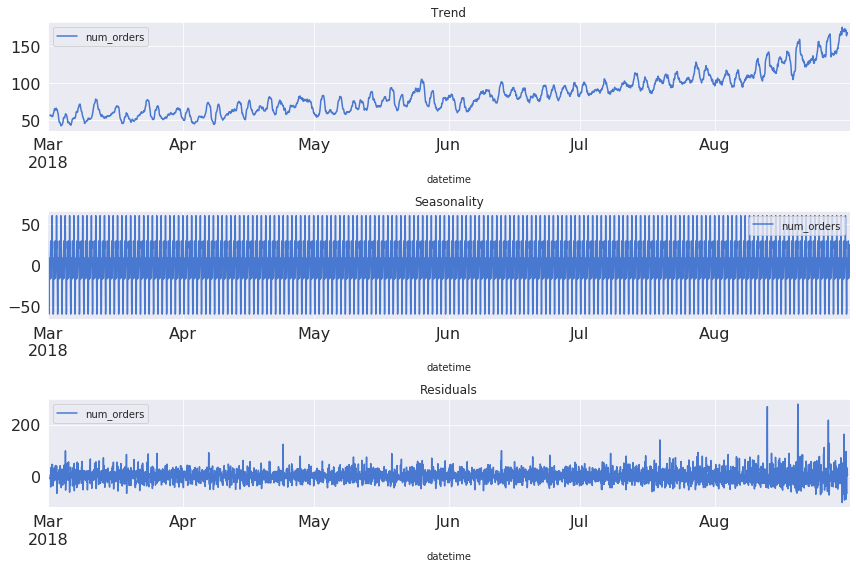

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим восходящий тренд в количестве заказов такси, среднее значение растёт. Сезонность имеет малый период. Посмотрим на неё подробнее:

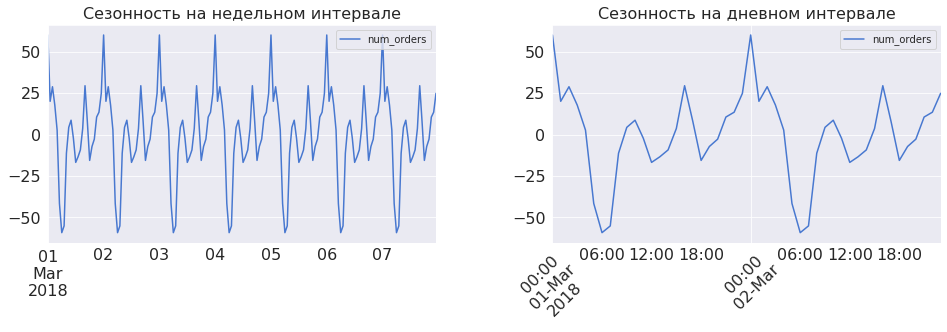

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
ax = decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
ax.set_xlabel('')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=label_angle)
plt.title('Сезонность на недельном интервале', fontsize=16)
    
plt.subplots_adjust(wspace=0.3) 
    
plt.subplot(1, 2, 2)
ax = decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
ax.set_xlabel('')
#ax.set_xticklabels(ax.get_xticklabels())
plt.xticks(rotation=45)
plt.title('Сезонность на дневном интервале', fontsize=16)
          
plt.show()

В количестве заказов есть выраженная сезонность - их количество каждый день начинает расти начиная с 18 часов и так продолжается до полуночи, затем количество заказов снижается, достигая минимума в 06 часов утра.

Посмотрим является ли наш временной ряд **стационарным** стохастическим процессом (его распределение со временем не меняется, т.е. не меняются его среднее и стандартное отклонение) или **нестационарным** (среднее и/или стандартное отклонение меняются).

In [11]:
df_M60['SMA'] = df_M60['num_orders'].rolling(7).mean()  # SMA - simple moving average
df_M60['STD'] = df_M60['num_orders'].rolling(7).std()  # STD - standard deviation

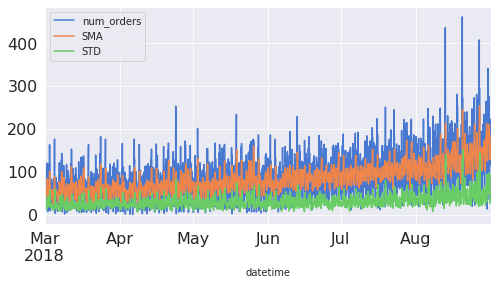

In [12]:
df_M60.plot()
plt.show()

Ряд нестационарный, т.к. меняется скользящее среднее значение и скользящее стандартное отклонение.
Чтобы сделать его стационарным, найдём разности его значений, т.к. разности временного ряда более стационарны, чем сам ряд. 

In [13]:
df_M60 = df_M60.drop(['SMA', 'STD'], axis=1)

In [14]:
df_M60_diff = df_M60 - df_M60.shift()
df_M60_diff['SMA'] = df_M60_diff['num_orders'].rolling(7).mean()  
df_M60_diff['STD'] = df_M60_diff['num_orders'].rolling(7).std()

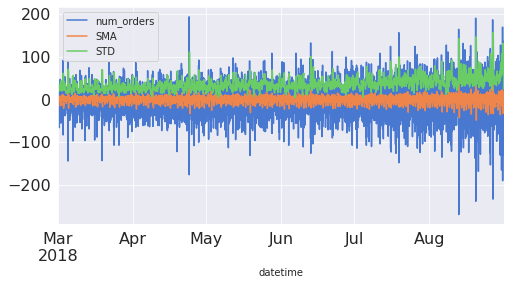

In [15]:
df_M60_diff.plot()
plt.show()

Ряд стал более стационарным, скользящее среднее значение уже не так монотонно возрастает, хотя скользящее отклонение имеет значительный размах.

# Построение моделей
Перед построением моделей создадим на основе имеющегося временного рядя дополнительные признаки.

In [16]:
def show_me_rmse(y_true, y_predict):
    """Возвращает значение RMSE метрики"""
    mse = mean_squared_error(y_true, y_predict)
    rmse = np.sqrt(mse)
    return round(rmse, 2)

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    '''Создает дополнительные признаки: календарные (год, месяц, день, 
    день недели, час), "отстающие" с временным лагом, скользящее среднее'''
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
# параметры max_lag, rolling_mean_size подбираются такие, чтобы модели давали
# как можно меньшее значение RMSE метрики
make_features(df_M60, 5, 7) 
df_M60.head(10)

,num_orders,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,42.571429


In [19]:
(df_M60.pivot_table(index='month',
                    values='num_orders',
                    aggfunc=['sum', 'median'])
      .style
      .set_caption('Изменение количества заказов по месяцам')
      .set_table_styles([{'selector': 'caption', 
                          'props': [('color', 'blue'), 
                                    ('font-size', '16px')]}
                                   ])
)

,sum,median
,num_orders,num_orders
month,,
3,42768,55
4,45939,61
5,54820,71
6,59906,83
7,74405,98
8,94973,122


In [20]:
(df_M60.groupby('day')['num_orders'].agg(['sum', 'median']).T
      .style
      .set_caption('Изменение количества заказов по дням месяца')
      .set_table_styles([{'selector': 'caption', 
                          'props': [('color', 'blue'), 
                                    ('font-size', '16px')]}
                                   ])
)

day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
sum,10418,11053,10525,10437,9931,11245,10919,11182,11166,11407,11806,11853,12926,12270,11750,12513,12031,12587,11757,13086,12179,12282,13455,13158,13307,12907,13899,13484,13346,14045,9887
median,70.5,71.5,65,72,65,73.5,73.5,77.5,75,74,79,78,83.5,77.5,81,79.5,79,84,73,79,77.5,78.5,89,85,89.5,83.5,88.5,90,81,86.5,90


<font color=blue> Оно же графически: </font>

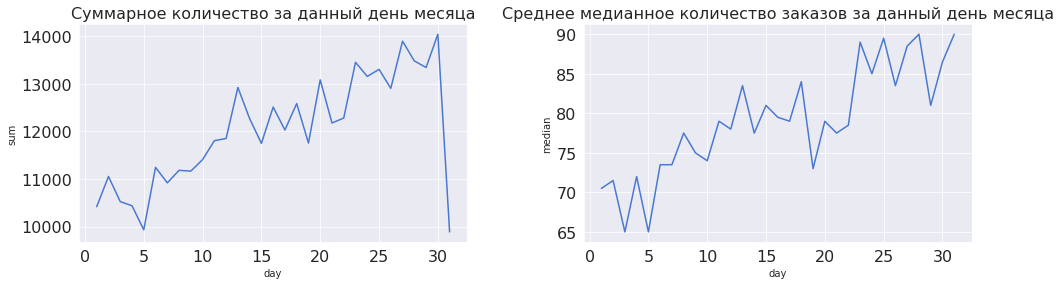

In [21]:
orders_by_day = df_M60.groupby('day')['num_orders'].agg(['sum', 'median'])

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=orders_by_day, x=orders_by_day.index, y='sum')
plt.title('Суммарное количество за данный день месяца', fontsize=16)
plt.subplots_adjust(wspace=0.3)  
plt.subplot(1, 2, 2)
sns.lineplot(data=orders_by_day, x=orders_by_day.index, y='median')
plt.title('Среднее медианное количество заказов за данный день месяца', fontsize=16)    
plt.show()

Т.к. это временной ряд, то при разбиении на обучающую, валидационную и тестовую выборки перемешивание отключаем. При этом получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет, поэтому здесь имеет NaN, данные строки из обучающей выборки удаляем. Размер тестовой выборки берем в 10% от исходного датафрейма.

In [22]:
# выделяем тестовую выборку в размере 10% от исходного датасета
train, test = train_test_split(df_M60, shuffle=False, test_size=0.1, random_state=123)

# из обучающей выделяем валидационную 
train, valid = train_test_split(train, shuffle=False, test_size=0.111, random_state=123) 

print('''Размер обучающей выборки: {:.1%}
Размер валидационной: {:.1%}
Размер тестовой: {:.1%}'''.format(train.shape[0]/df_M60.shape[0], 
                                  valid.shape[0]/df_M60.shape[0], 
                                  test.shape[0]/df_M60.shape[0]))

Размер обучающей выборки: 80.0%
Размер валидационной: 10.0%
Размер тестовой: 10.0%


In [23]:
train = train.dropna()

Проверим, что разбиение по времени прошло корректно (где заканчивается обучающая, начинается валидационная и затем тестовая):

In [24]:
print('Train:', train.index.min(), '-', train.index.max())
print('Valid:', valid.index.min(), '-', valid.index.max())
print('Test: ', test.index.min(), '-', test.index.max())

Train: 2018-03-01 07:00:00 - 2018-07-26 03:00:00
Valid: 2018-07-26 04:00:00 - 2018-08-13 13:00:00
Test:  2018-08-13 14:00:00 - 2018-08-31 23:00:00


Выделим целевую переменную и признаки в разные датафреймы:

In [25]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Подбор гиперпараметров и проверка на валидационной выборке

## DummyMedianModel
Все значения валидационной выборки предсказываем одним и тем же числом, например медианным значением числа заказов на обучающей выборке.

In [26]:
print("Среднее количество заказов в час:", 
          round(valid['num_orders'].mean(), 2))

Среднее количество заказов в час: 110.12


In [27]:
pred_median = np.ones(valid.shape[0]) * train['num_orders'].median()

print("RMSE для константной модели:", show_me_rmse(valid['num_orders'], 
                                                   pred_median))

RMSE для константной модели: 59.68


## DummyLastValueModel
Новое значение в тестовой выборке предсказываем предыдущим значением в ней.

In [28]:
pred_previous = valid.shift()
# последнее значение в обучающей выборке идет для предсказания 
# первого значения в тестовой
pred_previous.iloc[0] = train.iloc[-1]

print("RMSE для прогноза по предыдущему значению:", 
     show_me_rmse(valid['num_orders'], pred_previous['num_orders']))

RMSE для прогноза по предыдущему значению: 47.25


При среднем количестве ~110 заказов в час, чуть точнее дает прогноз модель на основе предыдущего значения ряда. Оно и понятно, количество заказов час от часа изменяется непрерывно и предыдущее значение ближе истине, чем простая медиана.

##  Simple LinearRegression

In [29]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_valid = lr_model.predict(X_valid)

print("RMSE на обучающей выборке:", show_me_rmse(y_train, y_pred_train))
print("RMSE на валидационной выборке: ", show_me_rmse(y_valid, y_pred_valid))

RMSE на обучающей выборке: 29.02
RMSE на валидационной выборке:  40.65


Простая линейная регрессия дает результат чуть лучше, чем простейшие амёбы :)

## LightGBM

In [30]:
# создадим контейнер для lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [31]:
# зададим конфигурацию как словарь
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metrics': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [32]:
# обучим машину
gbm_model = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's rmse: 55.7745
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 53.2877
[3]	valid_0's rmse: 51.0022
[4]	valid_0's rmse: 48.8868
[5]	valid_0's rmse: 47.1583
[6]	valid_0's rmse: 45.5988
[7]	valid_0's rmse: 44.0671
[8]	valid_0's rmse: 43.24
[9]	valid_0's rmse: 42.1213
[10]	valid_0's rmse: 41.0772
[11]	valid_0's rmse: 40.0944
[12]	valid_0's rmse: 39.3056
[13]	valid_0's rmse: 38.6614
[14]	valid_0's rmse: 38.0686
[15]	valid_0's rmse: 37.6174
[16]	valid_0's rmse: 36.9983
[17]	valid_0's rmse: 36.6009
[18]	valid_0's rmse: 36.0799
[19]	valid_0's rmse: 35.6449
[20]	valid_0's rmse: 35.3065
[21]	valid_0's rmse: 35.0438
[22]	valid_0's rmse: 34.7261
[23]	valid_0's rmse: 34.5825
[24]	valid_0's rmse: 34.3419
[25]	valid_0's rmse: 34.1987
[26]	valid_0's rmse: 34.0933
[27]	valid_0's rmse: 33.9564
[28]	valid_0's rmse: 33.8973
[29]	valid_0's rmse: 33.8063
[30]	valid_0's rmse: 33.6176
[31]	valid_0's rmse: 33.5766
[32]	valid_0's rmse: 33.4665
[33]	valid_0's rmse: 33

In [33]:
y_predict_gbm = gbm_model.predict(X_valid)
print("RMSE на валидационной выборке для LightGBM:", show_me_rmse(y_valid, y_predict_gbm))

RMSE на валидационной выборке для LightGBM: 32.6


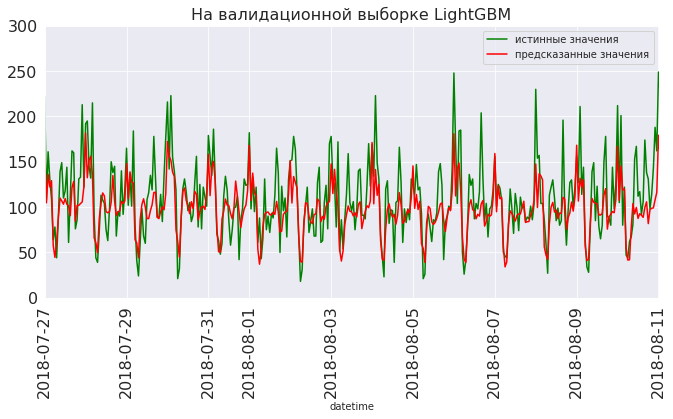

In [34]:
plt.figure(figsize = (11,5))
g = sns.lineplot(x=y_valid.index, y=y_valid.values, 
                 color='green', label='истинные значения')
g = sns.lineplot(x=y_valid.index, y=y_predict_gbm, 
                 color='red', label='предсказанные значения')
g.set_title('На валидационной выборке LightGBM', fontsize=16)
g.set(xlim=('2018-07-27', '2018-08-11')) # интервал дат указывать здесь
g.set(ylim=(0, 300))
plt.xticks(rotation=90)
plt.show()

- В целом значение RMSE метрики удовлятворяет требованию быть меньше 48, однако видно, что предсказанные значения количества заказов в часы пик сильно заниженны. Скорее всего, именно на этом моменте стоит сконцентрировать работу при подборе гиперпараметров, потому что модель и должна иметь хорошую предсказательную способность именно в пиковые часы.

## CatBoostRegressor

In [35]:
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.1,  
                              eval_metric='RMSE', depth=2, random_seed=123)

In [36]:
%%time
cat_model.fit(X_train, y_train, 
              verbose=False,
              plot=False)  # для визуализации требуются дополнительные библиотеки

CPU times: user 5.44 s, sys: 852 ms, total: 6.29 s
Wall time: 8.53 s


In [37]:
y_predict_cat = cat_model.predict(X_valid)
print("RMSE на валидационной выборке для CatBoost:", show_me_rmse(y_valid, y_predict_cat))

RMSE на валидационной выборке для CatBoost: 33.7


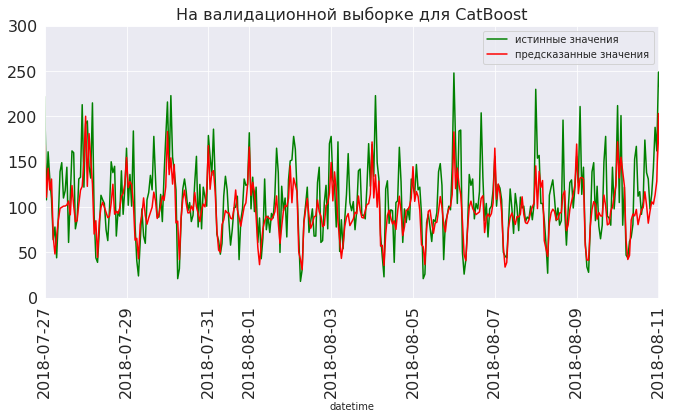

In [38]:
plt.figure(figsize = (11,5))
g = sns.lineplot(x=y_valid.index, y=y_valid.values, 
                 color='green', label='истинные значения')
g = sns.lineplot(x=y_valid.index, y=y_predict_cat, 
                 color='red', label='предсказанные значения')
g.set_title('На валидационной выборке для CatBoost', fontsize=16)
g.set(xlim=('2018-07-27', '2018-08-11')) # интервал дат указывать здесь
g.set(ylim=(0, 300))
plt.xticks(rotation=90)
plt.show()

- Для CatBoostRegressor метрика RMSE достигается похожая, однако визуально видно, что предсказания модели количества заказов в часы пик более сопоставими по масштабу, нет такой заниженной ~приоры~ оценки как, например, у LightGBM. Хорошо бы здесь ввести какую количественную меру, чтобы оценка была не только визуальная.

# Проверка на тестовой выборке

In [39]:
y_pred_test = lr_model.predict(X_test)
print("RMSE на тестовой выборке для линейной регрессии: ", show_me_rmse(y_test, y_pred_test))

RMSE на тестовой выборке для линейной регрессии:  53.52


In [40]:
# создадим прогнозные значения
y_predict_gbm_test = gbm_model.predict(X_test)
print("RMSE на тестовой выборке для LightGBM:", show_me_rmse(y_test, y_predict_gbm_test))

RMSE на тестовой выборке для LightGBM: 54.16


In [41]:
y_predict_cat_test = cat_model.predict(X_test)
print("RMSE на тестовой выборке для CatBoost:", show_me_rmse(y_test, y_predict_cat_test))

RMSE на тестовой выборке для CatBoost: 54.88


In [42]:
print('Train:', train.index.min(), '-', train.index.max())
print('Valid:', valid.index.min(), '-', valid.index.max())
print('Test: ', test.index.min(), '-', test.index.max())

Train: 2018-03-01 07:00:00 - 2018-07-26 03:00:00
Valid: 2018-07-26 04:00:00 - 2018-08-13 13:00:00
Test:  2018-08-13 14:00:00 - 2018-08-31 23:00:00


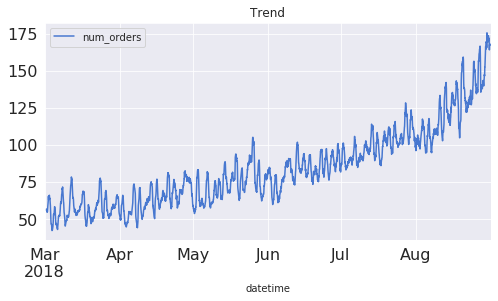

In [43]:
# для иллюстрации к выводам еще раз
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()

# Выводы
Наилучшие по значению RMSE метрики результаты на валидационной выборке достигаются у LightGBM И CatBoostRegressor моделей, 30.1 и 31.2 заказов, соответственно. Стоит заметить, что при похожих значениях данных метрик, предсказания CatBoost регрессора в часы пик ближе истинным значениям. Возможно стоит создать свою RMSE метрику, рассчитываемую как отклонение предсказанных значений от истинных **только** для пиковых часов (например, с 18 до 24 часов, см. график сезонности на дневном таймфрейме).

На тестовой выборке метрика RMSE ухудшается до 53-54, скорее всего это связано с тем, что обучающая и тестовая разнесены во времени. Мы обучаемся на данных за период с 01 марта по 26 июля, а финальное тестирование проводим на периоде с 13 по 31 августа. Таким образом при наличие растущего тренда (как на первом рисунке в разделе Анализ, привел его еще раз выше для удобства) ошибка предсказаний разнесенных во времени сильно увеличивается.